In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

# Smoothing
import statsmodels.api as sm

from pylab import rcParams

### Image Intensity Data Cleaning

The data files we are starting with have the following structure. Each image has a .csv file with the total area of the image and the mean intensity, as well as a .csv file with the area of each ROI and the mean intensity of each ROI. <br><br>
The approach to processing there are two key measurements and one calculation: <br>
1. Whole image mean intensity
2. Total ROI mean intensity (mean of the mean intensity of all ROIs)
3. intensity = roi_mean_intensity / total_mean_intensity <br><br>

The master dataframe will need to have the following column headers:
- image_name
- series_number (x-axis)
- sample (l or h and the sample number, i.e. 'low_2')
- l_or_h ('l' or 'h')
- roi_mean_intensity (mean intensity of the ROIs)
- channel (hue)
- series_sample (full sample name, i.e. 'low_2_cfp_02)
- roi_area (area of ROIs)
- total_mean_intensity (mean intensity of the whole image)
- total_area (area of the whole image)
- norm_intensity (roi_mean_intensity / total_mean_intensity)
- first_frame_norm_intensity (norm_intensity / the norm_intensity of a given sample's first frame)

**Creating a Master Dataframe**<br>
Process each file at one time and create a list holding the data that will eventuall represent every column, then create a dataframe with all the lists. 

In [45]:
directory = '/Volumes/ECD/pearson_microscopy_images'
l_h = ["low", "high"]
select_channel = ["cfp", "gfp", "cy5"]

# Lists that will eventually be the master dataframe columns
total_area = []
total_intensity = []
roi_area = []
roi_intensity = []
image_name = []
series_number = []
sample = []
channel = []
series_sample = []
l_or_h = []
first_frame_roi = []
first_frame_total = []
first_frame_index = []

counter = 0
for j in l_h: # iterate through the sample types
    for i in range(2, 6): # select samples by their name. There are sample folders labeled with 2-5 at the end of their name
        i = str(i) # turn this into a string because the number is going into the folder path
        for c in select_channel: # select the channel
            path = directory + "/" + j + "_t_spot" + i + "/" + c + "_results/*.csv" # create the path to the folder with samples
            for f in glob.glob(path, recursive=True): # recursively search the directory for all files
                counter = len(total_intensity) # counter to keep track of the first frame index
                if "120" in f: # ignore the timepoint 120 image
                    continue
                if f[-19:-14] == "total": # the files with 'total' in the path are the total intensity .csv files
                    total_int = pd.read_csv(f)
                    area = total_int.iloc[0]["Area"] # select first row in the 'Area' column (only one row in this file)
                    total_mean_int = total_int.iloc[0]["Mean"] # select first row in the 'Mean' column (only one row in this file)
                    total_intensity.append(total_mean_int) # add to the total_intensity list, which will eventually be a DataFrame column
                    total_area.append(area) # add to the total_area list, also will become a column
                    if 't2_total_intensity' in f: # get the total intensity of the first frame to calculate the first frame normalization 
                        first_frame_index.append(counter)
                        first_total = total_mean_int
                    first_frame_total.append(total_mean_int)
                if f[-17:-14] == "roi": # the files with 'roi' in the path contain each roi and its measuremnts in a row
                    roi_int = pd.read_csv(f)
                    roi_a = roi_int["Area"].sum() # calculate the area of all ROIs
                    mean_int = roi_int["Mean"].mean() # calculate the mean intensity across all ROIs
                    roi_area.append(roi_a) # add to roi_area list, which will become a DataFrame column
                    roi_intensity.append(mean_int) # add to roi_intensity list, which will become a DataFrame column
                    # only add the following once (will be the same for total and roi files)
                    s_num = f[-20:-18] # get the sample number
                    if "t" in s_num: # single digit samples will have a 't' because the above selects two string positions
                        s_num = s_num[-1] # remove the t
                        add_zero = True # indicate that a 0 can be added in front of the sample name (i.e. '07' instead of '7')
                    if s_num == '2' and add_zero is True: # get the first frame ROI mean intensity to calcualte the first frame normalization
                        first_frame_intensity = mean_int
                    first_frame_roi.append(first_frame_intensity) 
                    img_name = f[:-18] + ".TIF" # get the image name to add to DataFrame
                    image_name.append(img_name)
                    series_number.append(s_num)
                    n_sample = j + "_" + i
                    sample.append(n_sample)
                    s_s = n_sample + "_" + c + "_" + s_num 
                    if add_zero is True:
                        s_s = n_sample + "_" + c + "_0" + s_num  # add a '0' to single digit samples so that you can sort by value in a spreadsheet
                        add_zero = False
                    series_sample.append(s_s)
                    channel.append(c)
                    l_or_h.append(j)



In [97]:
a_roi_int = np.asarray(roi_intensity) # turn lists into numpy arrays to perform element wise division
a_total_int = np.asarray(total_intensity)
norm_intensity = a_roi_int / a_total_int # calculate the normalized intensity



dict_sample_intensities = {'image_name':image_name, 
                            'series_number':series_number, 
                            'sample':sample,
                            'l_or_h':l_or_h,
                            'channel':channel,
                            'series_sample':series_sample,
                            'roi_mean_intensity':roi_intensity,
                            'roi_area':roi_area,
                            'total_mean_intensity':total_intensity,
                            'total_area':total_area,
                            'norm_intensity':norm_intensity
                            }

In [98]:
all_data = pd.DataFrame(dict_sample_intensities)
all_data.to_csv('/Volumes/ECD/pearson_microscopy_images/intensity_data_v4.csv', index=False)

##### Start Here if Data is Already Cleaned

In [2]:
all_data = pd.read_csv('/Volumes/ECD/pearson_microscopy_images/intensity_data_v4.csv')

In [5]:
###################
#### SMOOTHING ####
###################

# Smooth the normalized intensities

spot_names = ['high_2', 'high_3', 'high_4', 'high_5', 'low_2', 'low_3', 'low_4', 'low_5']
channels = ['cfp', 'gfp', 'cy5']
fitted_dfs = []

for s in spot_names:
    for c in channels:
        df = all_data.loc[(all_data['sample'] == s) & (all_data['channel'] == c)].sort_values(by=['series_number']).reset_index()
        ff_idx = df.index[df['series_number'] == 2]
        lowess = sm.nonparametric.lowess
        fit = lowess(endog=df['norm_intensity'], exog=df['series_number'], frac=0.7, return_sorted=False)
        fit = fit / fit[ff_idx] # normalize to the first frame
        df['smoothed_intensity'] = fit
        fitted_dfs.append(df)

smoothed_all_data = pd.concat(fitted_dfs)

## Data Visualizations
### Trend Line Analysis<br>
#### **Average Across High Spot Samples**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


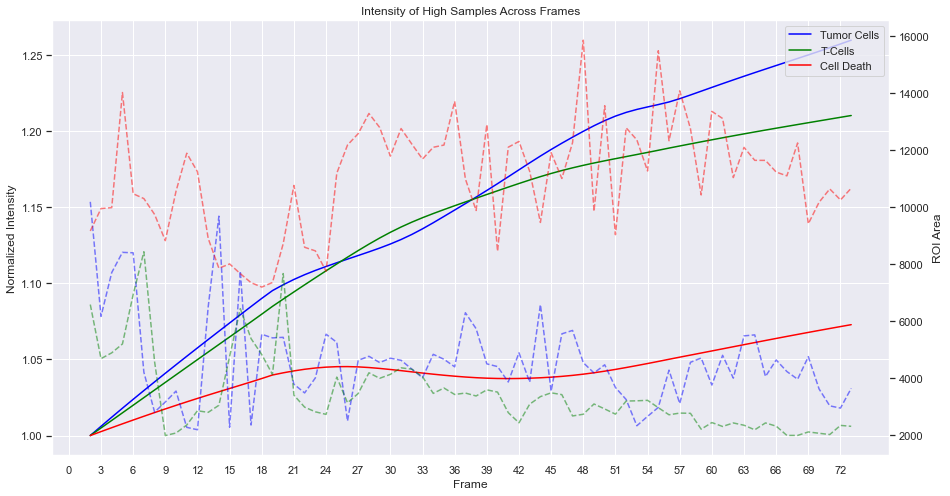

In [148]:
# High spots with First Frame Normalization and ROI Area
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='high')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', ci=None, palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.9,0.88))
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
l.get_legend().remove()
ax2.get_legend().remove()
ax2.grid(False)
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/half_smoothed_high_ffnorm_samples.png', dpi=300, bbox_inches='tight')

#### **Average Across Low Spot Samples**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


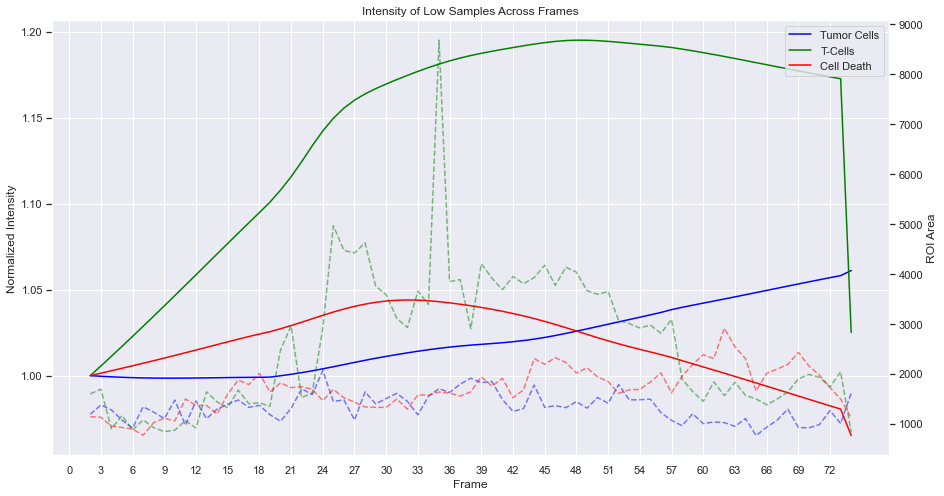

In [149]:
# Low spots with First Frame Normalization and ROI Area
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='low')]
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', ci=None, palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.9,0.88))
sns.lineplot(data=high_spots, x="series_number", y="roi_area", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
ax2.set_ylabel("ROI Area")
l.set(title='Intensity of Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
l.get_legend().remove()
ax2.get_legend().remove()
ax2.grid(False)
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/half_smoothed_low_ffnorm_samples.png', dpi=300, bbox_inches='tight')

#### **High SIY and Low SIY Together**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


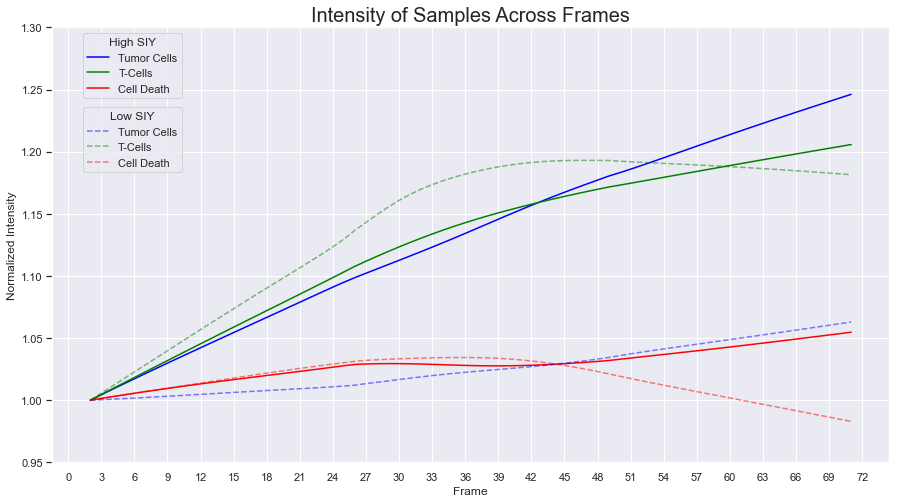

In [65]:
# Low spots with First Frame Normalization and ROI Area
smoothed_all_data = smoothed_all_data[smoothed_all_data['series_number']<74]
high_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='high')]
low_spots = smoothed_all_data.loc[(smoothed_all_data["l_or_h"]=='low')]
low_spots[["series_number"]] = low_spots[["series_number"]].apply(pd.to_numeric)
high_spots[["series_number"]] = high_spots[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
l = sns.lineplot(data=high_spots, x="series_number", y="smoothed_intensity", hue='channel', ci=None, palette=['blue', 'green', 'red'])
ax2 = plt.twinx()
plt.figlegend(labels=['Tumor Cells', 'T-Cells', 'Cell Death'], loc='upper right', bbox_to_anchor=(0.25,0.88), title='High SIY')
sns.lineplot(data=low_spots, x="series_number", y="smoothed_intensity", hue="channel", ax=ax2, alpha=0.5, linestyle="dashed", ci=None, palette=['blue', 'green', 'red'])
l.set_ylim(0.95, 1.3)
ax2.set_ylim(0.95,1.3)
l.set(ylabel='Normalized Intensity', xlabel='Frame')
l.set_title('Intensity of Samples Across Frames', fontsize=20)
l.get_legend().remove()
ax2.get_yaxis().set_visible(False)
leg = ax2.legend(bbox_to_anchor=(0.161,0.83), labels=['Tumor Cells', 'T-Cells', 'Cell Death'], title='Low SIY' )
leg_lines = leg.get_lines()
#leg_lines[0].set_linestyle('--')

#ax2.get_legend().remove()
ax2.grid(False)
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/allsamples_ffnorm_samples.png', dpi=300, bbox_inches='tight')

#### **High Spots: Tumor Cells (CFP)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


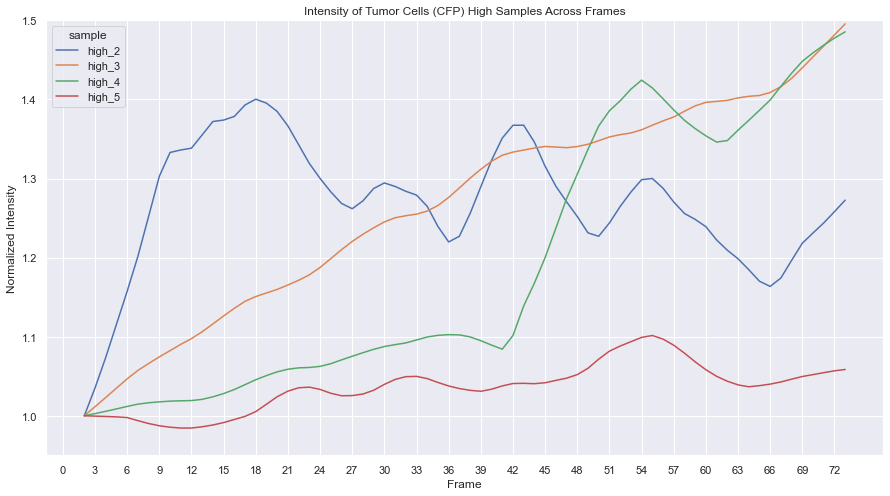

In [129]:
#### High Samples ####

#### CFP: Tumor Cells ####
cfp_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='cfp')]
cfp_high_samples[["series_number"]] = cfp_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.95, 1.5)
l = sns.lineplot(data=cfp_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of Tumor Cells (CFP) High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/cfp_high_samples.png', dpi=300, bbox_inches='tight')

#### **High Spots: T-Cells (GFP)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


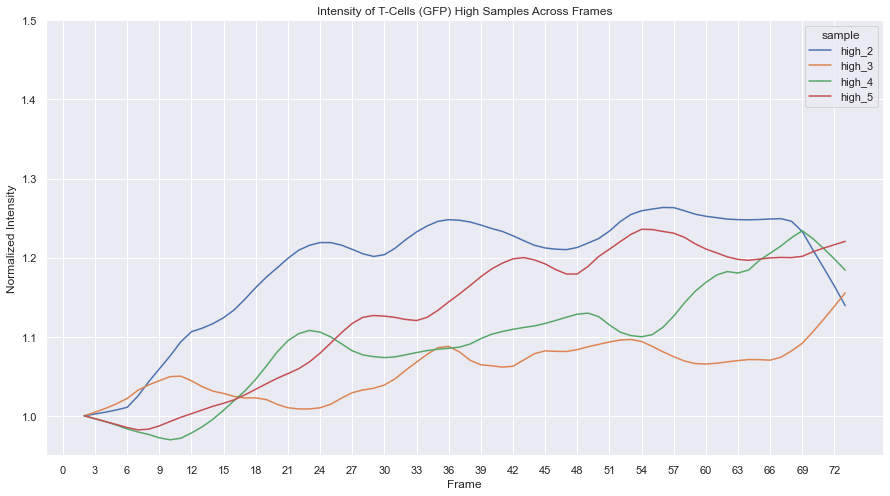

In [130]:
#### GFP: T-Cells ####
gfp_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='gfp')]
gfp_high_samples[["series_number"]] = gfp_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.95, 1.5)
l = sns.lineplot(data=gfp_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of T-Cells (GFP) High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/gfp_high_samples.png', dpi=300, bbox_inches='tight')


#### **High Spots: Cell Death (Cy5)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


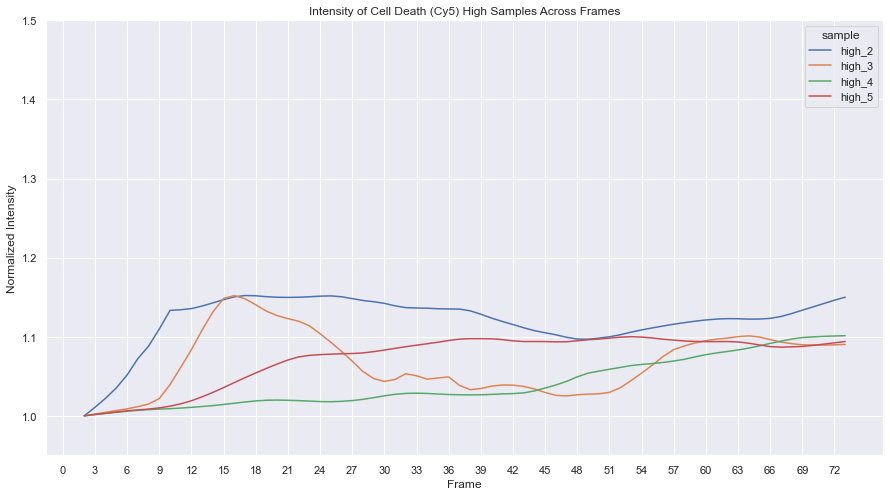

In [131]:
#### CY5: Cell Death ####
cy5_high_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'high') & (smoothed_all_data['channel']=='cy5')]
cy5_high_samples[["series_number"]] = cy5_high_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.95, 1.5)
l = sns.lineplot(data=cy5_high_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of Cell Death (Cy5) High Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/cy5_high_samples.png', dpi=300, bbox_inches='tight')


#### **Low Spots: Tumor Cells (CFP)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


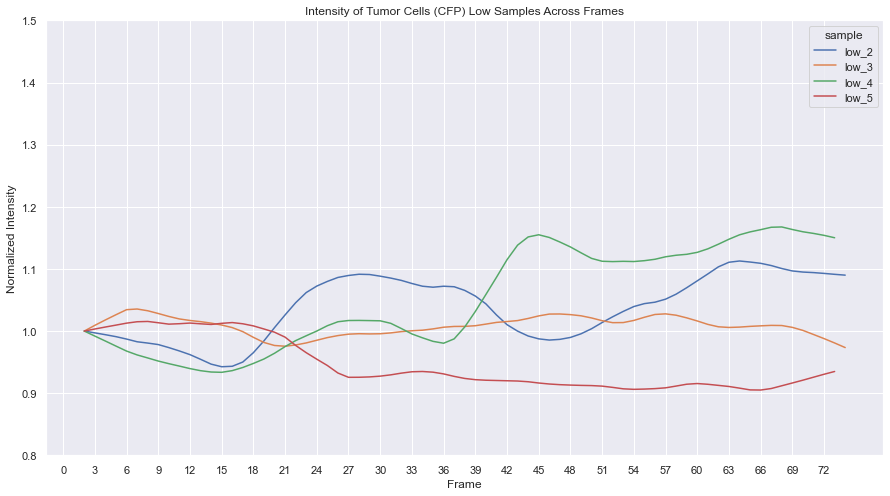

In [133]:
#### Low Samples ####

#### CFP: Tumor Cells ####
cfp_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='cfp')]
cfp_low_samples[["series_number"]] = cfp_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.8, 1.5)
l = sns.lineplot(data=cfp_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of Tumor Cells (CFP) Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/cfp_low_samples.png', dpi=300, bbox_inches='tight')


#### **Low Spots: T-Cells (GFP)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


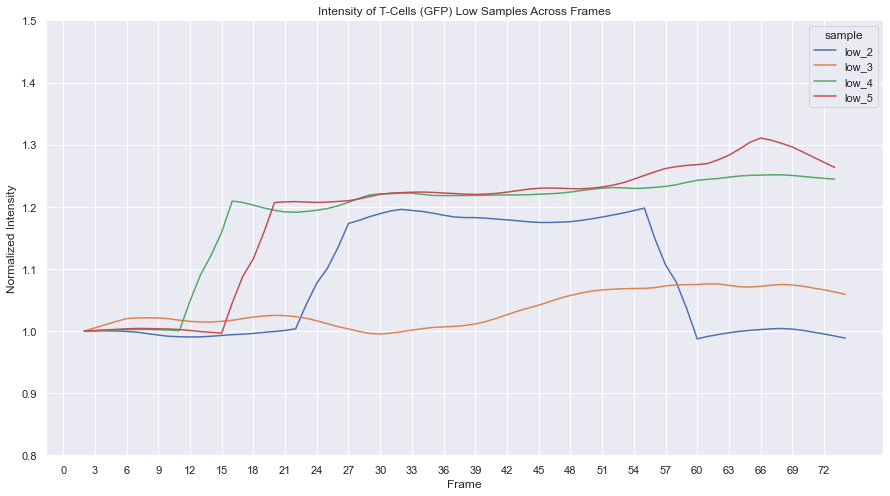

In [135]:
#### GFP: T-Cells ####
gfp_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='gfp')]
gfp_low_samples[["series_number"]] = gfp_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.8, 1.5)
l = sns.lineplot(data=gfp_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of T-Cells (GFP) Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/gfp_low_samples.png', dpi=300, bbox_inches='tight')


#### **Low Samples: Cell Death (Cy5)**

/Users/emmadyer/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


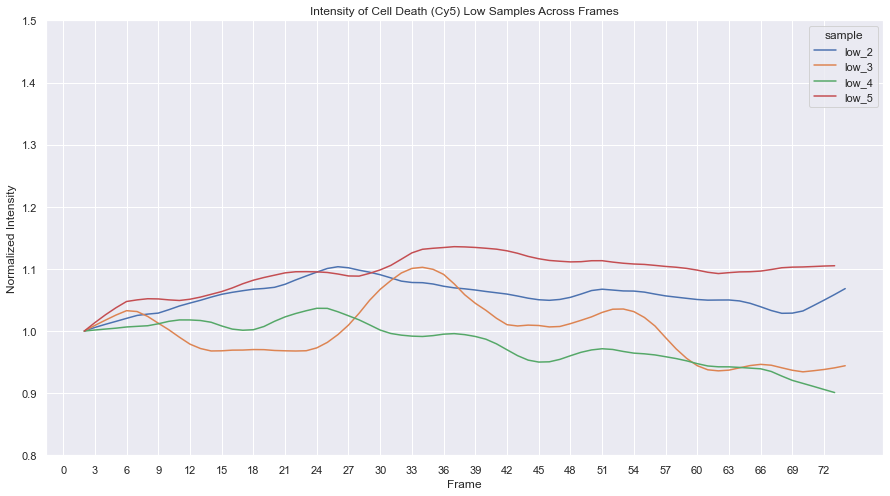

In [151]:
#### CY5: Cell Death ####
cy5_low_samples = smoothed_all_data.loc[(smoothed_all_data['l_or_h'] == 'low') & (smoothed_all_data['channel']=='cy5')]
cy5_low_samples[["series_number"]] = cy5_low_samples[["series_number"]].apply(pd.to_numeric)
sns.set(rc = {'figure.figsize':(15,8)})
plt.xticks(range(0,74,3))
plt.ylim(0.8, 1.5)
l = sns.lineplot(data=cy5_low_samples, x="series_number", y="smoothed_intensity", estimator=None, hue='sample')
l.set(title='Intensity of Cell Death (Cy5) Low Samples Across Frames', ylabel='Normalized Intensity', xlabel='Frame')
fig = l.get_figure()
fig.savefig('/Volumes/ECD/pearson_microscopy_images/figures/cy5_low_samples.png', dpi=300, bbox_inches='tight')


##### Extras

In [33]:
# This code is only needed if the samples are not normalized to the first frame during smoothing
# If the smoothing method does not normalize to the first frame, the you need to gather the 
# first frame value for each sample AFTER SMOOTHING to then calculate the smoothed first frame normalization
# This code takes the index positions of the first frame for a list of values, then creates a list
# with the first value in the position of all values for that sample. Run code below for example.

h = [1,1,1,1,1,1,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4]
idx = [0,6,11,15]
new_h = []  
for j, i in enumerate(idx):
    last_idx = len(h) - 1 
    if i == 0:
        last_num = i
        continue
    multiplier = i - last_num
    num = h[last_num]
    lst = [num] * multiplier
    new_h = new_h + lst
    last_num = i
    if j == len(idx) - 1:
        multiplier = last_idx - last_num
        num = h[last_idx]
        lst = [num] * (multiplier + 1)
        new_h = new_h + lst

print(new_h, '\n', h)
    


[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4] 
 [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4]
